In [1]:
import pandas as pd
import numpy as np

## Selenium & PhantomJS 를 이용하여 Web Scraping 

In [2]:
# Web Scraping Tool - AJAX 기반 (비동기식 자바스크립트)
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from bs4 import BeautifulSoup

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Windows
URL="https://www.google.com/flights/explore/#explore;f=JFK,EWR,LGA;t=HND,NRT,TPE,HKG,KIX;s=1;li=8;lx=12;d=2018-06-01"
PJS_PATH ="C:\\Users\\Jihye Lee\\Desktop\\phantomjs-2.1.1-windows\\phantomjs-2.1.1-windows\\bin\\phantomjs.exe"
driver = webdriver.PhantomJS(PJS_PATH)
dcap = dict(DesiredCapabilities.PHANTOMJS)
dcap["phantomjs.page.settings.userAgent"] = ("Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.80 Safari/537.36")
driver = webdriver.PhantomJS(desired_capabilities=dcap, executable_path=PJS_PATH)
driver.implicitly_wait(20)
driver.get(URL)

C:\Users\Jihye Lee\Anaconda3\lib\site-packages\selenium\webdriver\phantomjs\webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


### MAC
url = "https://www.google.com/flights/explore/#explore;f=JFK,EWR,LGA;t=HND,NRT,TPE,HKG,KIX;s=1;li=8;lx=12;d=2018-03-01"
#### PJS_PATH = "/Applications/anaconda3/pkgs/phantomjs-2.1.1-0/bin"
driver = webdriver.PhantomJS()
dcap = dict(DesiredCapabilities.PHANTOMJS)
dcap["phantomjs.page.settings.userAgent"] = ("Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.80 Safari/537.36")
driver = webdriver.PhantomJS(desired_capabilities=dcap, service_args=['--ignore-ssl-errors=true'])
driver.implicitly_wait(20)
driver.get(url)

In [5]:
driver.save_screenshot(r'flight_explorer.png')

True

## DOM 분석을 통한 가격 데이터 추출

DOM: 웹페이지의 구조를 만드는 요소들의 집합
(Body, div, class, id 등)

In [6]:
s = BeautifulSoup(driver.page_source, "lxml")

<!DOCTYPE html>
<html lang="en-US"><head><meta content="text/html; charset=utf-8" http-equiv="content-type"/><meta content="baseUrl=/flights/explore//static/" name="deals::gwt:property"/><title>Explore flights</title><meta content="Explore flights" name="description"/><script async="" src="https://apis.google.com/_/scs/abc-static/_/js/k=gapi.gapi.en.31Y1F2gcK7E.O/m=gapi_iframes,googleapis_client,plusone/rt=j/sv=1/d=1/ed=1/am=AAE/rs=AHpOoo_vCMbpDD_n0kFCsRS-Gz99puO__g/cb=gapi.loaded_0"></script><script language="javascript" type="text/javascript">
var __JS_ILT__ = new Date();
</script>
<style type="text/css">.gb_5a{background:white;height:100%;position:fixed;right:0;top:0;width:420px;z-index:1001}.gb_6a.gb_5a{left:0;min-height:400px;top:64px;width:initial}.gb_5a>button:only-of-type{background:url('https://www.gstatic.com/images/icons/material/system/1x/close_grey600_24dp.png');background-position:center;border-width:0;cursor:pointer;font-size:24px;height:20px;left:92%;position:relative;t
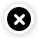
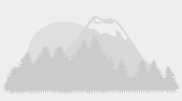

In [7]:
s

In [8]:
best_price_tags = s.findAll('div', 'CTPFVNB-w-e') 
best_prices = []
for tag in best_price_tags:
    best_prices.append(int(tag.text.replace('$','').replace(',','')))

In [9]:
best_price_tags

[<div class="CTPFVNB-w-e" style="top: 44.54077006435633px;">$787</div>,
 <div class="CTPFVNB-w-e" style="top: 36.03234483928557px;">$818</div>,
 <div class="CTPFVNB-w-e" style="top: 32.37578397593258px;">$954</div>,
 <div class="CTPFVNB-w-e" style="top: 32.91341249466575px;">$1,018</div>]

In [10]:
best_price = best_prices[0]
best_price

787

In [11]:
best_height_tags = s.find_all('div', 'CTPFVNB-w-f')
best_height_tags

[<div class="CTPFVNB-w-x CTPFVNB-w-f CTPFVNB-w-M" style="left: 48px; height: 69.96765516071443px;"></div>,
 <div class="CTPFVNB-w-x CTPFVNB-w-f" style="left: 234px; height: 73.62421602406742px;"></div>,
 <div class="CTPFVNB-w-x CTPFVNB-w-f" style="left: 282px; height: 73.08658750533425px;"></div>]

In [12]:
best_height_tags = s.find_all('div', 'CTPFVNB-w-f')
best_heights = []
for tag in best_height_tags:
    best_heights.append(float(tag.attrs['style'].split('height:')[1].replace('px;','')))
    
'''
tag.attrs -> style: , height: (2개의 attribute로 구성)
style 부분을 제외하고 height: 을 기준으로 나누어 2번째 text 가져오기
px; 부분을 공백으로 바꾸기

'''

'\ntag.attrs -> style: , height: (2개의 attribute로 구성)\nstyle 부분을 제외하고 height: 을 기준으로 나누어 2번째 text 가져오기\npx; 부분을 공백으로 바꾸기\n\n'

In [13]:
best_height = best_heights[0]
best_height

69.96765516071443

In [14]:
# Price per height
pph = np.array(best_price)/np.array(best_height)
pph

11.248054521653975

In [15]:
cities = s.findAll('div', 'CTPFVNB-w-o')
len(cities)

4

In [16]:
hlist=[]
for bar in cities[0]\
    .findAll('div', 'CTPFVNB-w-x'):
    hlist.append(float(bar['style']\
                       .split('height: ')[1].replace('px;',''))*pph)

In [17]:
fares = pd.DataFrame(hlist, columns = ['price'])

In [18]:
fares.describe()

,price
count,60.000000
mean,995.725112
std,91.235687
min,867.085194
25%,935.994256
50%,999.278089
75%,1034.963139
max,1192.293779


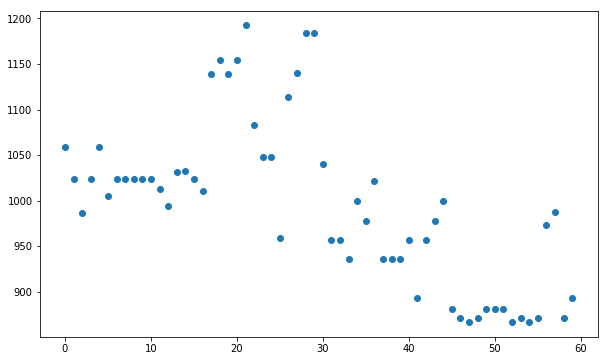

In [19]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.scatter(np.arange(len(fares['price'])), fares['price'])

In [20]:
# Price 데이터프레임 설정 (무작위재정렬?)
px = [x for x in fares['price']]
ff = pd.DataFrame(px, columns = ['fare']).reset_index()

In [21]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [22]:
X = StandardScaler().fit_transform(ff)
db = DBSCAN(eps = 0.45, min_samples = 1).fit(X)

Text(0.5,1.01,'Total Clusters: 4')

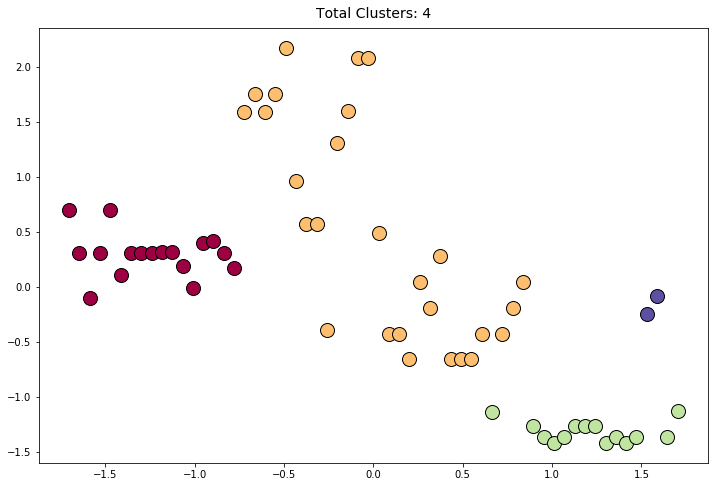

In [23]:
labels = db.labels_
clusters = len(set(labels))
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

plt.subplots(figsize = (12, 8))
for k, c in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o',
             markerfacecolor = c,
             markeredgecolor = 'k',
             markersize = 14)
plt.title("Total Clusters: {}".format(clusters), fontsize = 14, y = 1.01)


## IFTTT를 이용해 실시간 알림 보내기

- http://www.ifttt.com 계정 가입
- Web hook 및 SMS 채널 가입
- 'fare_alert' 메시지 설정

### 하나로 결합하기

In [24]:
import sys
import pandas as pd
import numpy as np
import requests

from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.common.by import By

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from bs4 import BeautifulSoup

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

import schedule
import time

In [26]:
def check_flight():
    URL="https://www.google.com/flights/explore/#explore;f=JFK,EWR,LGA;t=HND,NRT,TPE,HKG,KIX;s=1;li=8;lx=12;d=2018-06-01"

    PJS_PATH ="C:\\Users\\Jihye Lee\\Desktop\\phantomjs-2.1.1-windows\\phantomjs-2.1.1-windows\\bin\\phantomjs.exe"
    driver = webdriver.PhantomJS(PJS_PATH)
    dcap = dict(DesiredCapabilities.PHANTOMJS)
    dcap["phantomjs.page.settings.userAgent"] = ("Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.80 Safari/537.36")
    
    driver = webdriver.PhantomJS(desired_capabilities=dcap, executable_path=PJS_PATH)
    driver.implicitly_wait(20)
    driver.get(url)
    
    wait = WebDriverWait(driver, 20)
    wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, "span.CTPFVNB-v-c")))
    
    s = BeautifulSoup(driver.page_source, "lxml")
    
    best_price_tags = s.find_all('div', 'CTPFVNB-w-e')
    
    # 데이터 가져오기 확인 - 실패 또는 중지 시 경고
    if len(best_price_tags) < 4:
        print('Failed to Load Page Data')
        requests.post('https://maker.ifttt.com/trigger/fare_alert/with/key/pR1zp_YyHL7U_HiDBwtJDYVOEpQDF3cJxIEDj5AM7dN',
                      data={ "value1" : "script", "value2" : "failed", "value3" : "" })
        sys.exit(0)
    else:
        print('Successfully Loaded Page Data')
    
    best_prices = []
    for tag in best_price_tags:
        best_prices.append(int(tag.text.replace('$','').replace(',','')))        
    best_price = best_prices[0]
    
    best_height_tags = s.find_all('div', 'CTPFVNB-w-f')
    best_heights = []
    for tag in best_height_tags:
        best_heights.append(float(tag.attrs['style'].split('height:')[1].replace('px;','')))
    best_height = best_heights[0]
    
    # 높이(픽셀) 대비 가격
    pph = np.array(best_price)/np.array(best_height)
    cities = s.findAll('div', 'CTPFVNB-w-o')
    hlist=[]
    for bar in cities[0].findAll('div', 'CTPFVNB-w-x'):
        hlist.append(float(bar['style'].split('height: ')[1].replace('px;',''))*pph)

    fares = pd.DataFrame(hlist, columns = ['price'])
    px = [x for x in fares['price']]
    ff = pd.DataFrame(px, columns = ['fare']).reset_index()
    
    # 클러스터링 시작
    X = StandardScaler().fit_transform(ff)
    db = DBSCAN(eps = 0.45, min_samples = 1).fit(X)

    labels = db.labels_
    clusters = len(set(labels))
    
    pf = pd.concat([ff, pd.DataFrame(db.labels_, columns = ['cluster'])], axis = 1)
    rf = pf.groupby('cluster'['fare'].agg(['min', 'count']).sort_values('min', scending = True))
    
    # 규칙설정
    # 2개 이상 클러스터 필수
    # 클러스터의 최솟값이 최저가와 동일해야 함
    # 클러스터의 사이즈는 1/10 미만
    # 클러스터는 다음으로 낮은 요금의 클러스터 보다 100달러 더 낮아야 함
    if clusters >1 and ff['fare'].min() == rf.iloc[0]['min'] and rf.iloc[0]['count'] < rf['count'].quantile(.10) and rf.iloc[0]['fare'] + 100 < rf.iloc[1]['fare']:
        city = s.find('span', 'CTPFVNB-v-c').text
        fare = s.find('div', 'CTPFVNB-w-e').text
        requests.post('https://maker.ifttt.com/trigger/fare_alert/with/key/pR1zp_YyHL7U_HiDBwtJDYVOEpQDF3cJxIEDj5AM7dN',
                      data={ "value1" : "city", "value2" : "fare", "value3" : "" })
    else:
        print('no alert triggered')
        
    # 코드가 매 60분마다 수행되도록 스케줄러 설정
    schedule.every(60).minutes.do(check_flights)

    while 1:
        schedule.run_pending()
        time.sleep(1)  
        
